## Data Collection

In [1]:
import numpy as np
import pandas as pd

#### Collecting OHLC data of Apple using the yfinance library

In [2]:
import yfinance as yf

symbol = 'AAPL'
start_date = '2014-01-01'
end_date = '2024-12-04'

apple_data = yf.download(symbol, start = start_date, end = end_date)
apple_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,19.845715,19.893929,19.715000,19.754642,17.234293,234684800
2014-01-03,19.745001,19.775000,19.301071,19.320715,16.855730,392467600
2014-01-06,19.194643,19.528570,19.057142,19.426071,16.947641,412610800
2014-01-07,19.440001,19.498571,19.211430,19.287144,16.826439,317209200
2014-01-08,19.243214,19.484285,19.238930,19.409286,16.933002,258529600


## Data Preproccessing and Cleaning

#### Adding indicators as extra features to improve performance using the talib library

In [3]:
import talib as ta

# Adding MACD, RSI, SMA, EMA and ADX indicators
apple_data['MACD'], apple_data['MACD_signal'], _ = ta.MACD(apple_data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
apple_data['RSI'] = ta.RSI(apple_data['Close'], timeperiod=14)
apple_data['SMA_20'] = ta.SMA(apple_data['Close'], timeperiod=20)
apple_data['EMA_20'] = ta.EMA(apple_data['Close'], timeperiod=20)
apple_data['ADX'] = ta.ADX(apple_data['High'], apple_data['Low'], apple_data['Close'], timeperiod=14)

# Drop any rows with NaN values generated by the indicators
apple_data.dropna(inplace=True)

# Display the tail of the dataframe to check the new columns
apple_data.tail()

,Open,High,Low,Close,Adj Close,Volume,MACD,MACD_signal,RSI,SMA_20,EMA_20,ADX
Date,,,,,,,,,,,,
2024-11-26,233.330002,235.570007,233.330002,235.059998,235.059998,45986200,0.973024,0.043265,63.269972,226.998000,228.788941,11.601155
2024-11-27,234.470001,235.690002,233.809998,234.929993,234.929993,33498400,1.333510,0.301314,62.939122,227.239499,229.373803,12.516128
2024-11-29,234.809998,237.809998,233.970001,237.330002,237.330002,28481400,1.792200,0.599491,66.429185,227.810499,230.131537,13.860933
2024-12-02,237.270004,240.789993,237.160004,239.589996,239.589996,48137100,2.311432,0.941879,69.355673,228.644498,231.032342,15.707535
2024-12-03,239.809998,242.759995,238.899994,242.649994,242.649994,38861000,2.935999,1.340703,72.811617,229.676498,232.138785,17.766130


In [4]:
apple_data.to_csv('apple_data.csv')
df = apple_data

In [5]:
# Dropping unecessary columns which mostly won't contribute to the model
df = df.drop(['Open', 'High', 'Low', 'Adj Close'], axis=1)
df.head()

,Close,Volume,MACD,MACD_signal,RSI,SMA_20,EMA_20,ADX
Date,,,,,,,,
2014-02-20,18.969643,305858000,-0.077372,-0.250422,48.068566,18.784428,19.029094,25.838719
2014-02-21,18.758928,278784800,-0.093317,-0.219001,44.684310,18.729196,19.003364,24.784772
2014-02-24,18.841070,288909600,-0.098193,-0.194839,46.272328,18.696125,18.987908,23.993305
2014-02-25,18.645000,231952000,-0.116535,-0.179178,43.092256,18.645339,18.955250,23.383236
2014-02-26,18.476786,276217200,-0.142996,-0.171942,40.519393,18.664714,18.909682,23.279372


#### Scalling data so that every value lies between 0 and 1

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

df = pd.DataFrame(scaled_data, columns=df.columns, index=df.index)

df.head()

,Close,Volume,MACD,MACD_signal,RSI,SMA_20,EMA_20,ADX
Date,,,,,,,,
2014-02-20,0.002199,0.382965,0.422231,0.393970,0.389806,0.000656,0.000859,0.270666
2014-02-21,0.001259,0.346174,0.421210,0.396195,0.341025,0.000396,0.000739,0.253148
2014-02-24,0.001625,0.359933,0.420898,0.397905,0.363915,0.000240,0.000666,0.239993
2014-02-25,0.000750,0.282530,0.419724,0.399014,0.318077,0.000000,0.000513,0.229853
2014-02-26,0.000000,0.342684,0.418030,0.399526,0.280992,0.000091,0.000300,0.228126


## Splitting Data into Training and Testing Sets

In [7]:
from sklearn.model_selection import train_test_split
import numpy as np

# Set the sequence length
sequence_length = 30

# Function to create sequences
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i : i + sequence_length].values
        sequences.append(seq)
    return np.array(sequences)

sequences = create_sequences(df, sequence_length)

# Split sequences into train and test 
X_train, X_test = train_test_split(sequences, test_size=0.2, shuffle=False)

print("Training sequence shape:", X_train.shape)
print("Testing sequence shape:", X_test.shape)

Training sequence shape: (2148, 30, 8)
Testing sequence shape: (538, 30, 8)


## Building LSTM Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Build the LSTM Autoencoder
def build_lstm_autoencoder(sequence_length, num_features):
    model = models.Sequential()

    # Encoder Layer
    model.add(layers.LSTM(128, activation='relu', return_sequences=True, input_shape=(sequence_length, num_features)))
    model.add(layers.LSTM(64, activation='relu', return_sequences=False))

    # Bottleneck Layer
    model.add(layers.RepeatVector(sequence_length))

    # Decoder Later
    model.add(layers.LSTM(64, activation='relu', return_sequences=True))
    model.add(layers.LSTM(128, activation='relu', return_sequences=True))

    # Output layer
    model.add(layers.TimeDistributed(layers.Dense(num_features)))
    return model

sequence_length = 30
num_features = X_train.shape[2] 

# Build the model
autoencoder = build_lstm_autoencoder(sequence_length, num_features)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Summarize the model
autoencoder.summary()

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 30, 128)        │        70,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 30, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 30, 8)          │         1,032 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 252,424 (986.03 KB)

 Trainable params: 252,424 (986.03 KB)

 Non-trainable params: 0 (0.00 B)

## Model Training 

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

epochs = 50
batch_size = 64

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = autoencoder.fit(
    X_train, X_train,  
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, X_test),
    callbacks=[early_stopping]
)

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 0.0918 - val_loss: 0.1892
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0199 - val_loss: 0.0678
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0113 - val_loss: 0.0163
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0079 - val_loss: 0.0166
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0061 - val_loss: 0.0144
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0051 - val_loss: 0.0125
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0047 - val_loss: 0.0075
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0043 - val_loss: 0.0123
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0041 - val_loss: 0.0071
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0034 - val_loss: 0.0062
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0032 - val_loss: 0.0058
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0

## Data Visualization

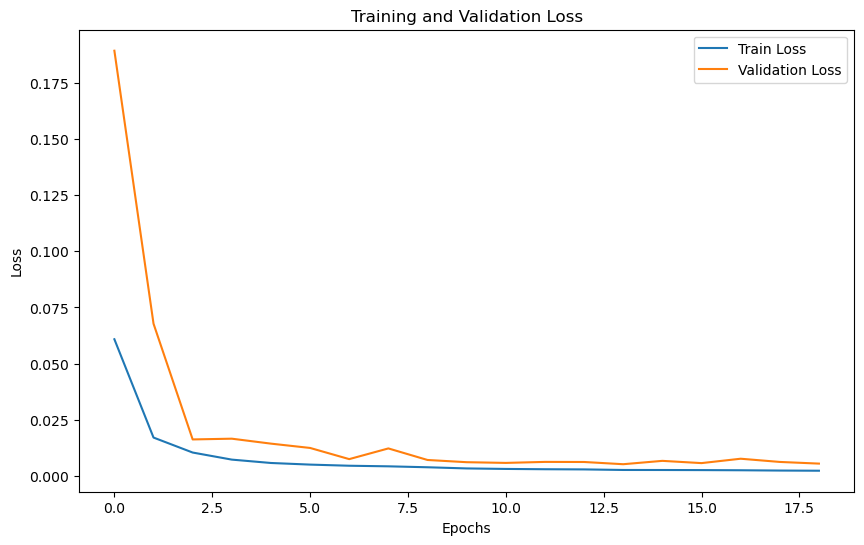

In [10]:
# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


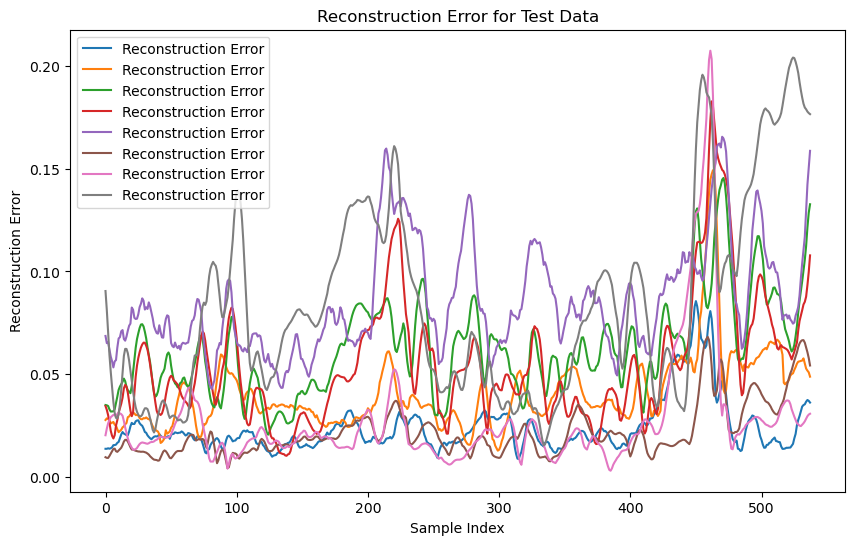

Number of anomalies detected: 216


In [11]:
# Predict (reconstruct) the test data
reconstructed = autoencoder.predict(X_test)

reconstruction_error = np.mean(np.abs(reconstructed - X_test), axis=1)

# Plot the reconstruction error
plt.figure(figsize=(10, 6))
plt.plot(reconstruction_error, label='Reconstruction Error')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error for Test Data')
plt.legend()
plt.show()

threshold = np.percentile(reconstruction_error, 95)
anomalies = reconstruction_error > threshold

print(f"Number of anomalies detected: {np.sum(anomalies)}")

In [12]:

model.save('lstm_autoencoder_model.h5')


NameError: name 'model' is not defined